# Modeling with linear regression

In this section, we will cover:

- fitting different linear repression models
- score analysis: MSE and variance explained: $R^2$
- residual analysis
- analysis of fitted values distribution
- most important features
- comparing the models: conclusions


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('df_resample.csv')
df.head()

symboling        make fuel_type aspiration num_of_doors body_style  \
0          1  mitsubishi       gas        std         four      sedan   
1          2      subaru       gas        std          two  hatchback   
2          1      nissan       gas        std         four      wagon   
3          0      subaru       gas        std         four      sedan   
4          1       dodge       gas        std         four      sedan   

  drive_wheels engine_location  wheel_base  length  ...  engine_size  \
0          fwd           front        96.3   172.4  ...          122   
1          fwd           front        93.3   157.3  ...          108   
2          fwd           front        94.5   170.2  ...           97   
3          fwd           front        97.2   172.0  ...          108   
4          fwd           front        93.7   157.3  ...           90   

   fuel_system  bore stroke compression_ratio  horsepower peak_rpm  city_mpg  \
0         2bbl  3.35   3.46               8.5        88.0   5000.0        25   
1         2bbl  3.62   2.64               8.7        73.0   4400.0        26   
2         2bbl  3.15   3.29               9.4        69.0   5200.0        31   
3         2bbl  3.62   2.64               9.5        82.0   4800.0        32   
4         2bbl  2.97   3.23               9.4        68.0   5500.0        31   

   highway_mpg   price  
0           32  6989.0  
1           31  7603.0  
2           37  7349.0  
3           37  7126.0  
4           38  7609.0  

[5 rows x 25 columns]

In [3]:
X = df.copy()
X.drop('price', axis=1, inplace=True)
y = np.log(df.price) # as discussed, we are going to use the log transform here

## Train-test split

To validate out model, lets split the data on train and test sets, so we can evaluate the predictions on the test set later.


In [4]:
# now the split in a stratified way
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=95276
)

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

with open('category_list', 'rb') as file:
    cat_cols = pickle.load(file)

# numeric columns
num_cols = [col for col in X_train.columns if col not in cat_cols]

# normalize numeric features
scaler = StandardScaler()
num_scaled = scaler.fit_transform(X_train[num_cols])

# encode categories
encoder = OneHotEncoder(sparse=False)
cat_encoded = encoder.fit_transform(X_train[cat_cols])

# all together
X_train_proc = np.concatenate([cat_encoded, num_scaled] ,axis=1)
X_train_proc.shape

(7000, 73)

In [10]:
# apply transformations on test set
num_scaled = scaler.transform(X_test[num_cols])

# encode categories
cat_encoded = encoder.transform(X_test[cat_cols])

# all together
X_test_proc = np.concatenate([cat_encoded, num_scaled] ,axis=1)
X_test_proc.shape

(3000, 73)

## Regularized models - Sklearn

Now lets fit some models that uses regularization for feature selection. 

Ridge regression uses a penalty L2 factor for the least important regressors. 

- L2: least squared deviation $resid = \sum{(y_i - \hat y_i)^2} + \lambda \sum{\beta^2}$

However, the least squares regularization is not robust: it is sensitive to outliers.

### Transformation on data

Preprocessing will be required here: 

- feature normalization / scaling

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import regression
import time


def make_regressor(model_name, model, grid_params):
    start_time = time.time()
    grid = GridSearchCV(
        model, grid_params,
        scoring='neg_mean_squared_error',
        n_jobs=-1, cv=3
        )
    grid.fit(X_train_proc, y_train)
    
    model = grid.best_estimator_
    parameters = model.get_params()

    y_predictions = np.exp(model.predict(X_test_proc))
    mse = regression.mean_squared_error(np.exp(y_test), y_predictions)
    r2 = model.score(X_test_proc, y_test)
    end_time = time.time()
    elapsed = end_time - start_time

    message = f'Score r2: {r2:.4} \nScore MSE: {mse:.4} \nTime: {elapsed:.2}s'
    print(model_name)
    print(message)
    print(parameters)
    
    stats = {
        'model name': model_name,
        'r2': r2,
        'mse': mse,
        'parameters': parameters
    }
    return model, y_predictions, stats

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
grid_params = {'fit_intercept': [True, False]}
name = 'Linear Regression'

linear_results = make_regressor(name, model, grid_params)

Linear Regression
Score r2: 0.9706 
Score MSE: 1.912e+06 
Time: 0.17s
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


In [30]:
from sklearn.linear_model import Ridge

model = Ridge()
grid_params = {'alpha': [.001, .01, .1, 1, 10]}
name = 'Ridge Regression'
ridge_results = make_regressor(name, model, grid_params)

Ridge Regression
Score r2: 0.9706 
Score MSE: 1.912e+06 
Time: 0.16s
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


## Regularized models - Lasso

Lasso regression uses a stronger penalty for the least important regressors, the L1.

That said, lasso will perform feature selection and it is not a stable solution.

- L1: least absolute deviation: $resid = \sum{(y_i - \hat y_i)^2} + \lambda \sum{|\beta|}$



In [31]:
from sklearn.linear_model import Lasso

model = Lasso()
grid_params = {'alpha': [.001, .01, .1, 1, 10]}
name = 'Lasse Regression'
lasso_results = make_regressor(name, model, grid_params)

Lasse Regression
Score r2: 0.9619 
Score MSE: 2.357e+06 
Time: 0.38s
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Huber Regressor

Huber uses L2 and L1 penalty. This makes it specially strong against outliers:

In [33]:
from sklearn.linear_model import HuberRegressor

model = HuberRegressor(max_iter=1000)
grid_params = {
    'alpha': [.001, .01, .1, 1, 10],
    'epsilon': [1, 2, 5, 10]
}
name = 'HUbber Regression'
hubber_results = make_regressor(name, model, grid_params)


HUbber Regression
Score r2: 0.9706 
Score MSE: 1.912e+06 
Time: 1.4e+02s
{'alpha': 0.1, 'epsilon': 5, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1e-05, 'warm_start': False}


C:\Users\BJ571WQ\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Comparing models - MSE and $R^2$

In [181]:
df_comparisson = pd.DataFrame({'model_ols': ols_predictions,
                               'ridge': ridge_predictions,
                               'lasso': lasso_predictions,
                               'hubber': huber_predictions,
                              'actual_price': np.exp(y_test)
                             })
df_comparisson.sample(10).round(2)

model_ols     ridge     lasso    hubber  actual_price
5841   14332.85  14772.02  11567.48  13885.70       15250.0
7108    6765.94   6603.32   7539.55   6750.47        6649.0
1383    9401.58   9584.22  10521.32   9511.52       10198.0
2502   12862.39  12648.45  12439.52  12889.71       13295.0
2710   11078.97  10924.65  11950.14  11339.05        9639.0
3047    6041.90   5940.80   7375.22   5500.33        6295.0
4285    8954.70   9037.73  10059.74   9181.44        9298.0
9630    6783.83   6872.21   7491.22   6487.58        6575.0
228     8725.74   8133.58  10736.26   7766.05        8921.0
8562    8695.72   8609.97   8446.36   8144.22        7995.0

In [182]:
df_comparisson.describe().round(2) # min and max prices are ok

model_ols     ridge     lasso    hubber  actual_price
count    3000.00   3000.00   3000.00   3000.00       3000.00
mean    13092.66  13095.12  12361.63  13123.65      13152.12
std      7607.19   7633.48   5216.12   7608.87       7836.94
min      5151.00   5150.58   5581.04   5249.26       5118.00
25%      7532.80   7703.26   8474.59   7446.55       7775.00
50%     10276.94  10254.49  10429.53  10375.00      10198.00
75%     16030.48  16015.68  15302.30  15618.80      16506.00
max     42302.85  45603.49  40385.31  44378.04      45400.00

In [40]:
df_comparisson.to_pickle('df_comparisson.pkl')

In [183]:
df_scores = pd.DataFrame({'mse': [ols_mse,
                     ridge_mse, 
                     lasso_mse,
                     huber_mse],
                         'r2': [ols_r2,
                     ridge_r2, 
                     lasso_r2,
                     huber_r2]
                         },
                         index=['model_ols', 'ridge', 'lasso', 'hubber']
                        )
                        
df_scores.sort_values(by='mse').round(4)

mse      r2
ridge      1.802008e+06  0.9713
model_ols  1.934713e+06  0.9689
hubber     3.277986e+06  0.9550
lasso      1.594458e+07  0.8181

In [42]:
df_scores.to_pickle('df_scores.pkl')

## Residual analysis

In a good model, what we should expect from the residuals:
- their mean should be zero
- they should be homoscedastic
- they should be normal
- they should have no correlation with the fitted values
- they should have no correlation with any of the features


### Residual mean

In [43]:
# OLS
model_ols.resid.mean() # good!

-6.615492420253224e-09

In [44]:
# Ridge
model_ridge_resids = model_ridge.predict(X_train) - y_train
model_ridge_resids.mean() # good!

2.7548562759637867e-12

In [45]:
# Lasso
model_lasso_resids = model_lasso.predict(X_train) - y_train
model_lasso_resids.mean() # good!

-2.898453435496783e-12

In [46]:
# Huber
model_huber_resids = model_huber.predict(X_train) - y_train
model_huber_resids.mean() # nope!

-84.10494030218992

### Residuals vs fitted values

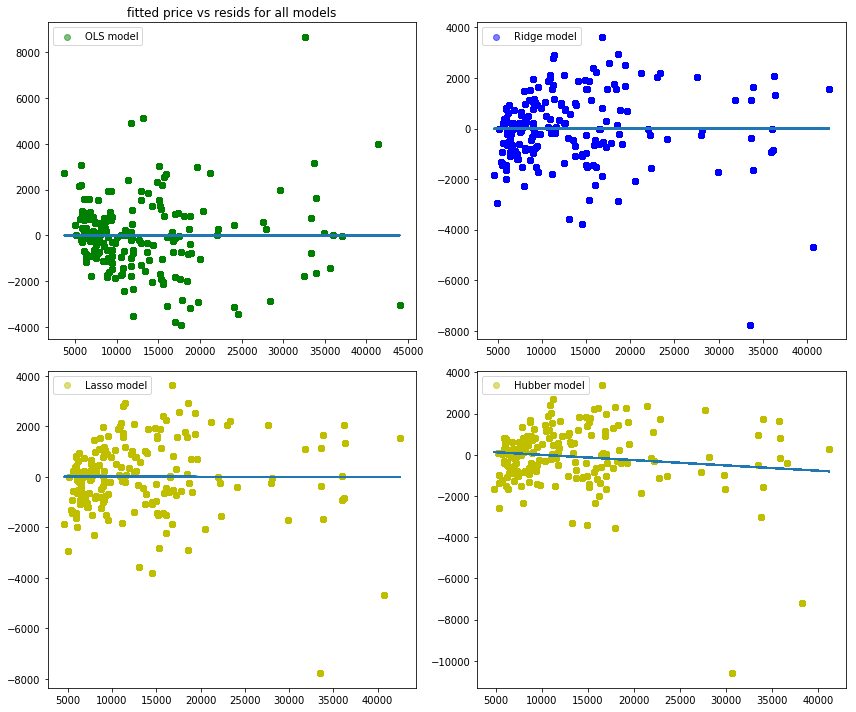

In [47]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)
plt.title('fitted price vs resids for all models')
plt.scatter(model_ols.fittedvalues, model_ols.resid, c="g", alpha=0.5, label="OLS model")
b, m = polyfit(model_ols.fittedvalues, model_ols.resid, 1)
plt.plot(model_ols.fittedvalues, b + m * model_ols.fittedvalues, '-')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc=2)


plt.subplot(2, 2, 2)
plt.scatter(model_ridge.predict(X_train), model_ridge_resids, c="b", alpha=0.5, label="Ridge model")
b, m = polyfit(model_ridge.predict(X_train), model_ridge_resids, 1)
plt.plot(model_ridge.predict(X_train), b + m * model_ridge.predict(X_train), '-')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc=2)


plt.subplot(2, 2, 3)
plt.scatter(model_lasso.predict(X_train), model_lasso_resids, c="y", alpha=0.5, label="Lasso model")
b, m = polyfit(model_lasso.predict(X_train), model_lasso_resids, 1)
plt.plot(model_lasso.predict(X_train), b + m * model_lasso.predict(X_train), '-')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc=2)


plt.subplot(2, 2, 4)
plt.scatter(model_huber.predict(X_train), model_huber_resids, c="y", alpha=0.5, label="Hubber model")
b, m = polyfit(model_huber.predict(X_train), model_huber_resids, 1)
plt.plot(model_huber.predict(X_train), b + m * model_huber.predict(X_train), '-')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc=2)

plt.tight_layout()
plt.show()


Huber model residuals seems to have some correlation with $\hat y$

In [48]:
from scipy.stats.stats import pearsonr

pearsonr(model_huber.predict(X_train), model_huber_resids)

(-0.13000205379448529, 3.1774528951646964e-26)

Nope, all ok for the Hubber model

### Testing residuals for normality

The Shapiro's test tests the null hypothesis of normality:


In [49]:
# OLS
import scipy.stats as st
st.shapiro(model_ols.resid) # not normal!

/data/data-erick/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9467343688011169, 1.2471556332490872e-43)

In [50]:
# Ridge
st.shapiro(model_ridge_resids) # not normal!

/data/data-erick/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9506106376647949, 1.9632191485190687e-42)

In [51]:
# Lasso
st.shapiro(model_lasso_resids) # not normal!

/data/data-erick/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.95025235414505, 1.5105997445421528e-42)

In [52]:
# Hubber
st.shapiro(model_huber_resids) # normal ...

/data/data-erick/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.851108968257904, 0.0)

### Correlation between residuals and features

In a good model, residuals cannot be correlated to any feature. 

Lets check that for the Ridge model:

In [53]:
from scipy.stats.stats import pearsonr

for feat in num_cols:
    print(feat, "\n", pearsonr(X_train_4later[feat], model_ridge_resids))

wheel_base 
 (-1.4003582859898878e-06, 0.99990933517835479)
length 
 (1.756374185852324e-06, 0.99988628451912254)
width 
 (-1.2574826827668787e-06, 0.99991858445875048)
height 
 (7.8176824156691975e-07, 0.99994938430093361)
curb_weight 
 (-3.797454235559836e-06, 0.99975413629064946)
engine_size 
 (-3.8471709637247909e-06, 0.99975091772610181)
bore 
 (8.9786472595204995e-07, 0.99994186940128194)
stroke 
 (4.9476568951461345e-07, 0.99996797328663012)
compression_ratio 
 (3.6947997553470614e-06, 0.99976078300490479)
horsepower 
 (-2.5938799551408359e-07, 0.9999832064353672)
peak_rpm 
 (-9.9613065319792174e-07, 0.99993550850322954)
city_mpg 
 (-2.75655220193949e-08, 0.99999819508980514)
highway_mpg 
 (-7.8903570714943728e-07, 0.99994891297882671)


All ok here: there is no correlation between resids and any of the features

### Correlation between residuals and $\hat y$

In a good model, residuals cannot be correlated to the fitted values. 

We have already saw before that the Ridge is ok in his regard:

In [54]:
from scipy.stats.stats import pearsonr
pearsonr(model_ridge.predict(X_train), model_ridge_resids)

(-5.6538446317043605e-05, 0.9963394713107252)

## Fitted values distribution analysis

We expect that the fitted values follows the same distribution of the original prices.

### Ridge Model:

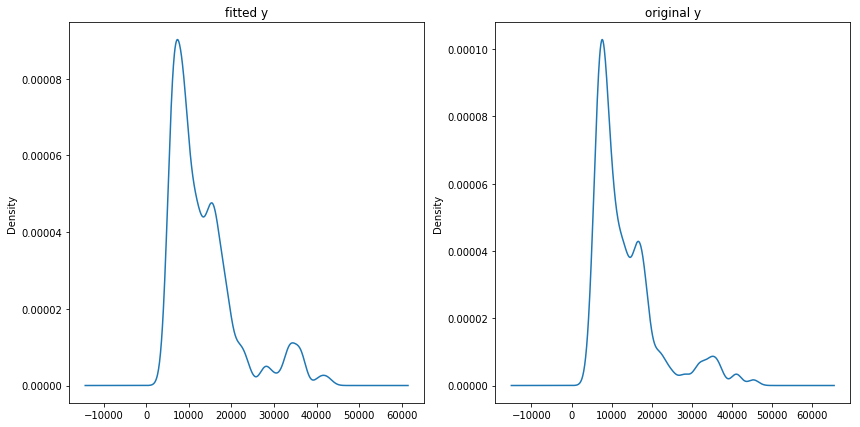

In [55]:
import matplotlib.pyplot as plt

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False)

all_prices_pred = model_ridge.predict(X_proc)

pd.Series(all_prices_pred).plot(kind='kde', legend=False, ax=ax,  figsize=(14,7), title='fitted y')
pd.Series(y).plot(kind='kde', legend=False, figsize=(14,7), title='original y')

### OLS Model

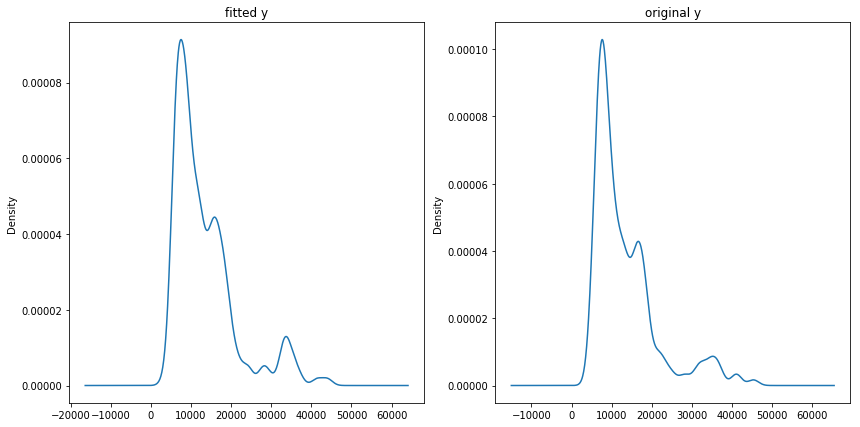

In [56]:
import matplotlib.pyplot as plt

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False)

all_prices_pred = model_ols.predict(X)

pd.Series(all_prices_pred).plot(kind='kde', legend=False, ax=ax,  figsize=(14,7), title='fitted y')
pd.Series(y).plot(kind='kde', legend=False, figsize=(14,7), title='original y')

## Most important features



### OLS

In [57]:
index = model_ols.pvalues[model_ols.pvalues<.05].index

coefs = model_ols.params[index]

df_coef_ols = pd.DataFrame({'coefs_abs': np.abs(np.round(coefs,2)),
                            'coef_value': np.round(coefs,2),
                            'feats': coefs.index})

df_coef_ols[~df_coef_ols.feats.str.startswith('make')].sort_values('coefs_abs', ascending=False).head(10)

coef_value  coefs_abs  \
C(fuel_system)[T.idi]             9925.11    9925.11   
C(fuel_system)[T.spfi]            7131.38    7131.38   
C(make)[T.porsche]                6448.56    6448.56   
Intercept                         6340.05    6340.05   
C(make)[T.isuzu]                 -5859.51    5859.51   
C(num_of_cylinders)[T.twelve]    -5819.47    5819.47   
C(make)[T.mercedes-benz]          4860.42    4860.42   
C(make)[T.plymouth]              -4753.42    4753.42   
C(make)[T.bmw]                    4660.72    4660.72   
C(make)[T.dodge]                 -4635.57    4635.57   

                                                       feats  
C(fuel_system)[T.idi]                  C(fuel_system)[T.idi]  
C(fuel_system)[T.spfi]                C(fuel_system)[T.spfi]  
C(make)[T.porsche]                        C(make)[T.porsche]  
Intercept                                          Intercept  
C(make)[T.isuzu]                            C(make)[T.isuzu]  
C(num_of_cylinders)[T.twelve]  C(num_of_cylinders)[T.twelve]  
C(make)[T.mercedes-benz]            C(make)[T.mercedes-benz]  
C(make)[T.plymouth]                      C(make)[T.plymouth]  
C(make)[T.bmw]                                C(make)[T.bmw]  
C(make)[T.dodge]                            C(make)[T.dodge]

## Comparing the models - conclusions

- residual analysis shows better results for the ols, ridge and lasso models: their residual means are closer to zero (not normal though)
- all models have no correlation between fitted values and residuals
- MSE analysis shows better results for the Ridge model: smallest MSE
- $R^2$ analysis shows better results for the Ridge model
- OLS model gets a pretty close score to Ridge but it uses only 20 features, while Ridge uses 24

In [58]:
df_scores.sort_values(by='mse').round(4)

mse      r2
ridge      2.156401e+06  0.9676
lasso      2.156436e+06  0.9676
hubber     2.377322e+06  0.9643
model_ols  2.774196e+06  0.9579

Now lets proceed to the next step: machine learning!

[back to github](https://github.com/erickfis/Challenges)

[erickfis@gmail.com](mailto:erickfis@gmail.com)
